In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import scvelo as scv
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = Path(config['data_path'])
# local utils
sys.path.insert(1, '../utils/')
from utils import *

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [2]:
# list files in data_path
list_files = list(data_path.glob('*.h5*'))
# print names
for i, file in enumerate(list_files):
    print(i, file.name)

0 LiaoZhang120520_data.h5
1 cov19_hamster_data.h5
2 MelmsIzar290421_data.h5
3 Pancov19_prepd_neutros.h5
4 cov19_dexa_hamster_data.h5
5 ChuaEils290620_data.h5
6 PhoRob_timecourse_all.h5
7 Cov19Hamster_timecourse_integrated_neutrophils.h5
8 Cov19Hamster_timecourse_integrated_all.h5
9 WendischSander241022_data.h5
10 Pancov19_prepd_all.h5
11 MesAur_timecourse_all.h5
12 Pancov19_prepd_endos.h5


In [3]:
superdata = sc.read(data_path / "Pancov19_prepd_all.h5")

# Import color options
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
            
    return s.replace('_', ', ')

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

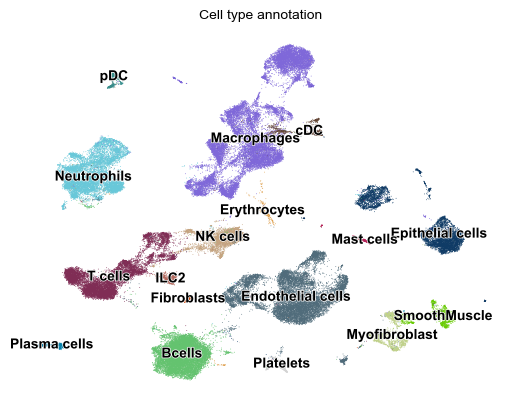

In [4]:
scv.pl.scatter(superdata, basis='umap_scVI', color='celltype_rough', legend_loc='on data', frameon=False, title='Cell type annotation', color_map=celltype_rough_colors)

# Rev3 14

Line 190. Why do the authors only report a couple of genes? Certainly, they did a pathway assessment and could define key genes in various canonical pathways - in the supplement would be fine. Also what are the top 10 genes in each group and do they cross reference?

# Rev1 Major 2 (done)

Is the frequency of Th17 cells higher in the lungs of infected Roborovski hamsters compared to Syrian hamsters?

## Identify Th17 cells

In [57]:
tdata = superdata[superdata.obs['celltype_rough'] == 'T cells'].copy()
# recalculate neighbors and UMAP
sc.pp.neighbors(tdata, use_rep='X_scVI')
sc.tl.umap(tdata)

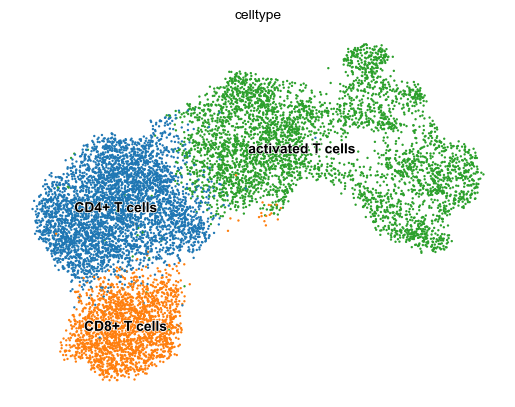

In [58]:
scv.pl.scatter(tdata, basis='umap', legend_loc='on data', frameon=False, color='celltype')

In [110]:
markers =  ["Il17a", "Il17f", "Il21", "Il22", "Rorc", "Il6ra", "Il21r", "Il23r", "Stat3", "Ccr6"]
markers = list(np.intersect1d(markers, tdata.var_names))
good_markers = ['Ccr6', 'Il21r', 'Rorc', 'Stat3', 'Cd4', 'Cd8a', 'Cd8b', 'Socs1', 'Socs3', 'Tbx21', 'Gata3', 'Foxp3', 'Ccr4']

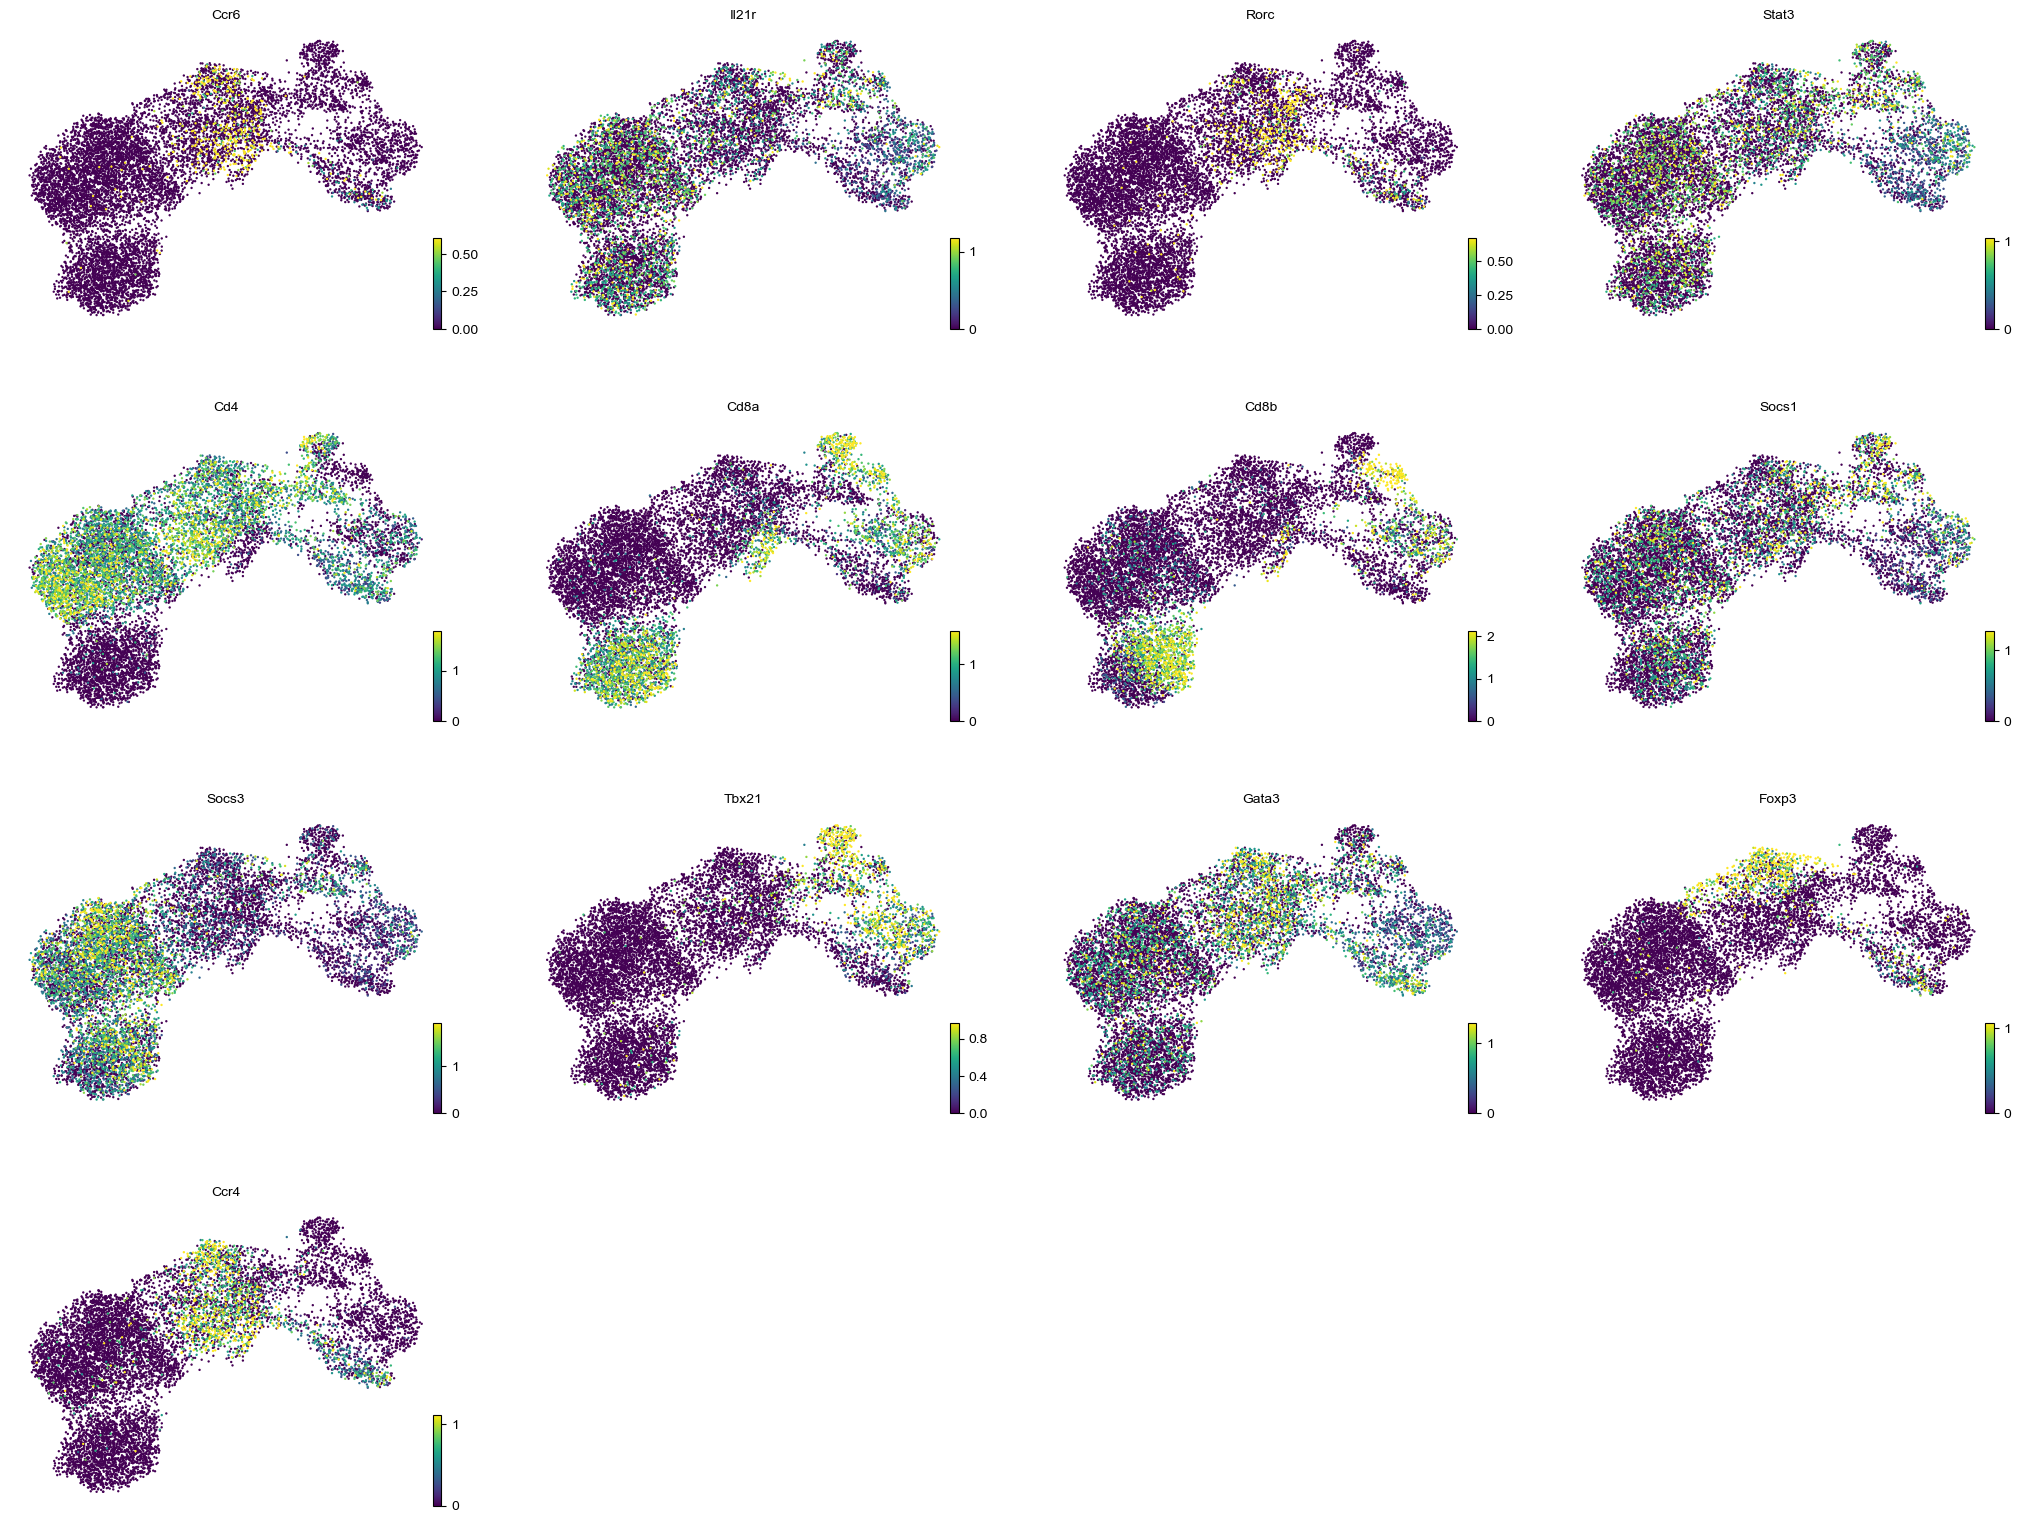

In [111]:
scv.pl.scatter(tdata, basis='umap', legend_loc='on data', frameon=False, color=good_markers, ncols=4, perc=[3, 97])

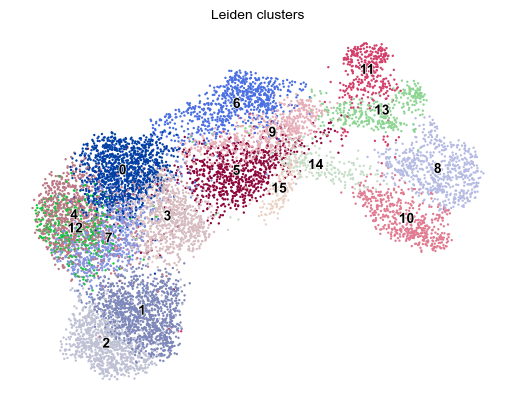

In [112]:
sc.tl.leiden(tdata, resolution=1.5)
scv.pl.scatter(tdata, basis='umap', legend_loc='on data', frameon=False, color='leiden', title='Leiden clusters', color_map='tab20')

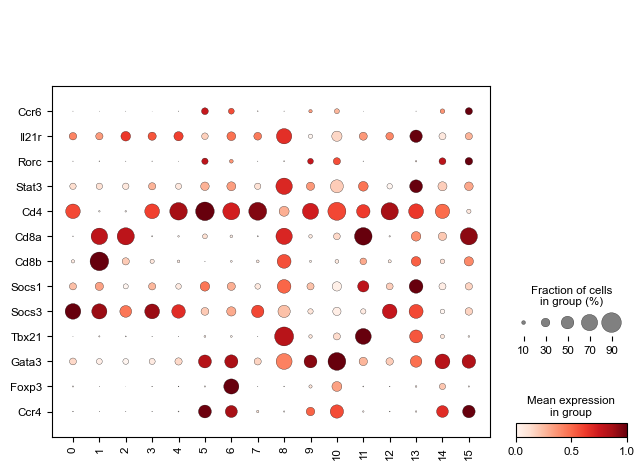

In [113]:
sc.pl.dotplot(tdata, good_markers, groupby='leiden', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True)

In [114]:
df = extract_df(tdata, ['leiden'] + good_markers)
sdf = df.groupby('leiden').mean()
sdf['Cd8'] = sdf[['Cd8a', 'Cd8b']].mean(axis=1)

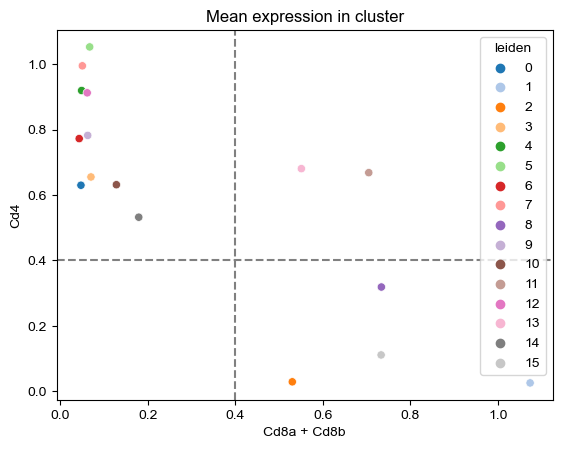

In [115]:
sns.scatterplot(data=sdf, x='Cd8', y='Cd4', hue=sdf.index, palette='tab20')
pl.axvline(0.4, color='grey', linestyle='--')
pl.axhline(0.4, color='grey', linestyle='--')
pl.ylabel('Cd4')
pl.xlabel('Cd8a + Cd8b')
pl.title('Mean expression in cluster')
pl.show()

In [116]:
types = {
    'CD4+CD8-': list(sdf[sdf['Cd8'] < 0.4].index),
    'CD4+CD8+': list(sdf[(sdf['Cd4'] > 0.4) & (sdf['Cd8'] > 0.4)].index),
    'CD4-CD8+': list(sdf[sdf['Cd4'] < 0.4].index)
}

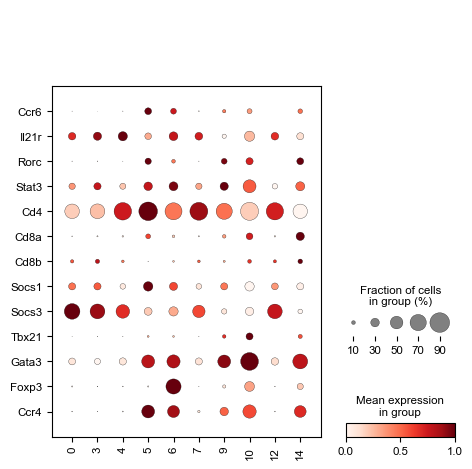

In [117]:
# We are looking for Rorc+ Foxp3- Ccr6+ cells
# Also good: Stat3+ Socs1+ Socs3-
sc.pl.dotplot(tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])], good_markers, groupby='leiden', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True)

In [304]:
# Cluster 5 is Th17

## Compare Frequency of Th17 cells

In [305]:
df = extract_df(tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])], ['leiden', 'Time', 'hamster', 'Organism', 'Dosage'])
df['subtype'] = 'CD4+CD8- T cells'
df['subtype'][df.leiden == '5'] = 'Th17 cells'

In [306]:
counts = df.value_counts(['Time', 'hamster', 'Organism', 'Dosage', 'subtype'], sort=False).unstack(fill_value=0)
counts['Th17_frequency'] = (counts['Th17 cells'] / counts.sum(axis=1))
counts = counts.reset_index(drop=False)
counts['Dosage_Time'] = counts['Dosage'].astype(str) + '_' + counts['Time'].astype(str)

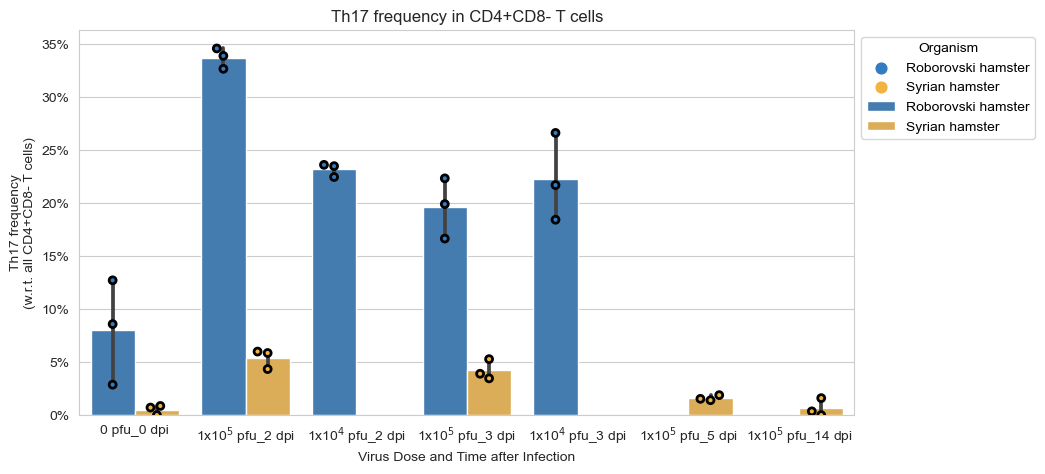

In [307]:
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 5))
    sns.barplot(data=counts.reset_index(), x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors)
    sns.swarmplot(data=counts.reset_index(), x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors, edgecolor='k', linewidth=2, dodge=True, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Th17 frequency\n(w.r.t. all CD4+CD8- T cells)')
ax.set_xlabel('Virus Dose and Time after Infection')
pl.title('Th17 frequency in CD4+CD8- T cells')
pl.savefig("../results/figures/Revision/Rev1_Major2_Th17_frequency.pdf", bbox_inches='tight', dpi=300)
pl.show()

In [308]:
# Foldchange w.r.t. D0
counts = df.value_counts(['Time', 'hamster', 'Organism', 'Dosage', 'subtype'], sort=False).unstack(fill_value=0)
counts['Th17_frequency'] = (counts['Th17 cells'] / counts.sum(axis=1))

baseline_mean = counts.reset_index().groupby(['Time', 'Organism']).mean().loc['0 dpi'].Th17_frequency
baseline_std = counts.reset_index().groupby(['Time', 'Organism']).std().loc['0 dpi'].Th17_frequency
fc_r = counts.loc[:,:,'Roborovski hamster'].Th17_frequency / baseline_mean['Roborovski hamster']
fc_s = counts.loc[:,:,'Syrian hamster'].Th17_frequency / baseline_mean['Syrian hamster']
fc = pd.concat({'Roborovski hamster': fc_r, 'Syrian hamster': fc_s}, axis=0)
fc.drop('0 dpi', level=1, inplace=True)
fc = fc.reset_index()
fc.columns = ['Organism', 'Time', 'Hamster', 'Dosage', 'Foldchange']
fc['l2fc'] = np.log2(fc.Foldchange)
fc['Dosage_Time'] = fc['Dosage'].astype(str) + '_' + fc['Time'].astype(str)

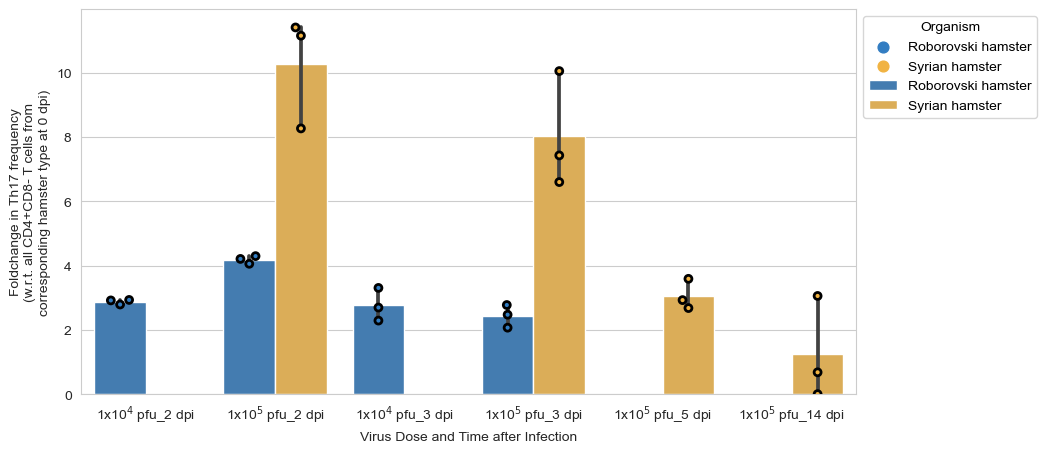

In [309]:
y_key = 'Foldchange'
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 5))
    sns.barplot(data=fc, x='Dosage_Time', y=y_key, hue='Organism', palette=Organism_colors)
    sns.swarmplot(data=fc, x='Dosage_Time', y=y_key, hue='Organism', palette=Organism_colors, edgecolor='k', linewidth=2, dodge=True, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel(f'{y_key} in Th17 frequency\n(w.r.t. all CD4+CD8- T cells from\ncorresponding hamster type at 0 dpi)')
ax.set_xlabel('Virus Dose and Time after Infection')
pl.savefig("../results/figures/Revision/Rev1_Major2_Th17_frequency_foldchange.pdf", bbox_inches='tight', dpi=300)
pl.show()

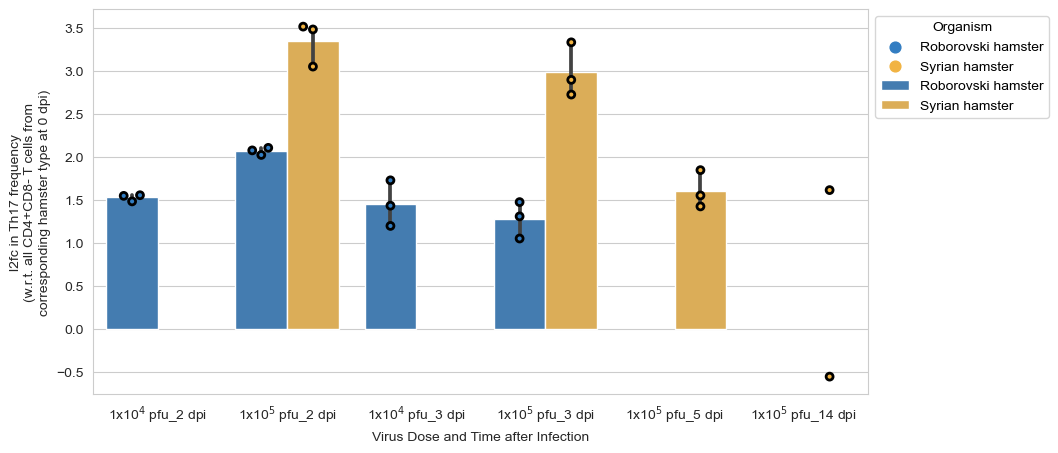

In [310]:
y_key = 'l2fc'
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 5))
    sns.barplot(data=fc, x='Dosage_Time', y=y_key, hue='Organism', palette=Organism_colors)
    sns.swarmplot(data=fc, x='Dosage_Time', y=y_key, hue='Organism', palette=Organism_colors, edgecolor='k', linewidth=2, dodge=True, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel(f'{y_key} in Th17 frequency\n(w.r.t. all CD4+CD8- T cells from\ncorresponding hamster type at 0 dpi)')
ax.set_xlabel('Virus Dose and Time after Infection')
pl.savefig("../results/figures/Revision/Rev1_Major2_Th17_frequency_l2fc.pdf", bbox_inches='tight', dpi=300)
pl.show()

# Rev1 Major 3b

Additionally, it would be pertinent to discuss whether Sars-Cov2 entry receptors, like ACE2, CD147, AXL, TMPRSS2 and many others, are more prominently expressed in Roborovski hamster neutrophils compared to those in Syrian hamsters.

In [48]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10094153/
entry_receptors = [
    'Ace2', 'Tmprss2', 'Ctsl', 'Nrp1', # main entry factors
    'Bsg', # Cd147
    'Axl', 'Kremen1'
]
# not found: 'Cd209', 'Havcr1' aka Tim1
# Expression too low:  'Asgr1', 'Clec4g' 

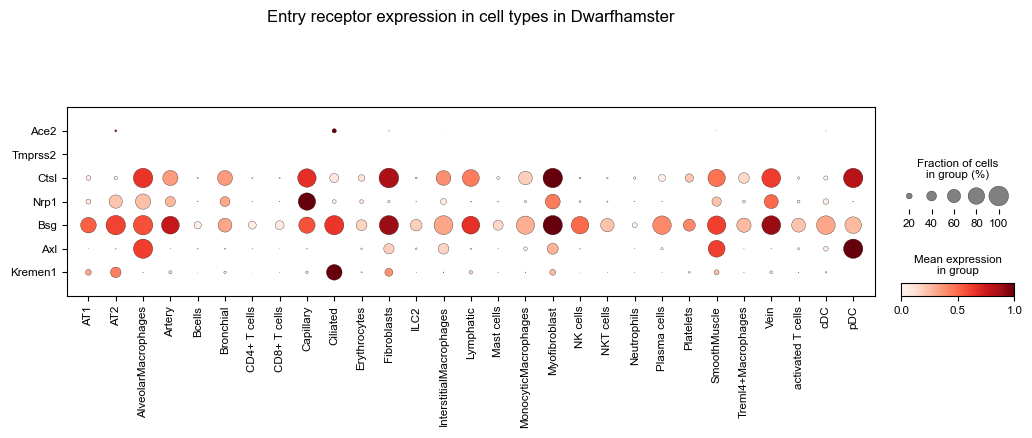

In [55]:
sc.pl.dotplot(superdata[superdata.obs.organism=='Dwarfhamster'], 
              entry_receptors, groupby='celltype', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True,
              title='Entry receptor expression in cell types in Dwarfhamster')

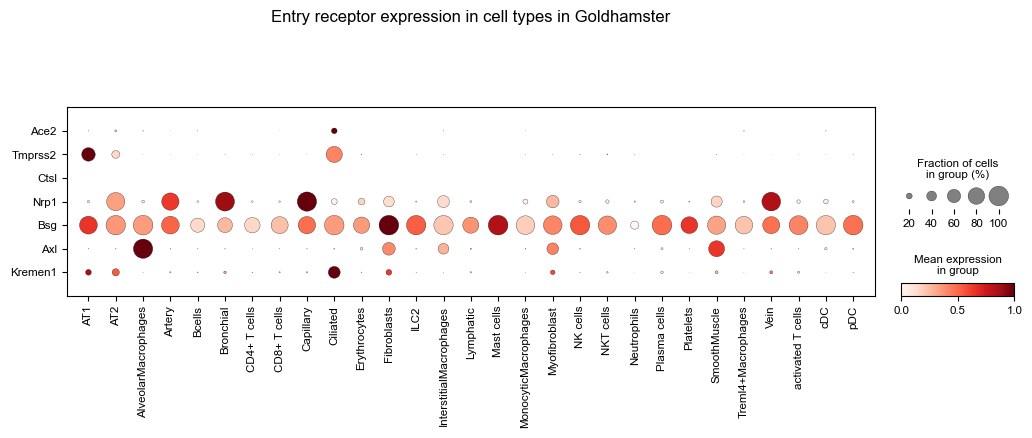

In [54]:
sc.pl.dotplot(superdata[superdata.obs.organism=='Goldhamster'], 
              entry_receptors, groupby='celltype', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True,
              title='Entry receptor expression in cell types in Goldhamster')

In [242]:
percent_expressings = {}
mean_expressions = {}
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    df = extract_df(superdata[superdata.obs.Organism==Organism], ['celltype'] + entry_receptors)
    # this is black magic here
    df.set_index('celltype', inplace=True)
    percent_expressing = pd.concat(
        {gene: (df > 0).value_counts(['celltype', gene], normalize=False, sort=False).loc[:, True].reindex(sorted(df.index.unique()), fill_value=0) \
            / df.value_counts(['celltype'], sort=False).reset_index().set_index('celltype')[0] \
            for gene in entry_receptors if df[gene].sum()>0}, axis=1
    ).fillna(0).T * 100
    percent_expressing.columns = percent_expressing.columns.astype(str)
    percent_expressing.sort_index(axis=1, inplace=True)

    df = extract_df(superdata[superdata.obs.Organism==Organism], ['celltype'] + entry_receptors)
    mean_expression = df.groupby('celltype').mean().T
    mean_expression.columns = mean_expression.columns.astype(str)
    mean_expression.sort_index(axis=1, inplace=True)
    
    percent_expressings[Organism] = percent_expressing
    mean_expressions[Organism] = mean_expression

In [248]:
np.setdiff1d(*[x.columns for x in percent_expressings.values()])

array([], dtype=object)

In [249]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Wedge
def split_dotplot(color_df1, size_df1, color_df2, size_df2, figsize=None, ax=None, dpi=None, title=None, show=True, cmap='Reds'):
    if ax is None:
            fig, ax = fig, ax = pl.subplots(figsize=figsize, dpi=dpi)
    for side, color_df, size_df in zip(['left', 'right'], [color_df1, color_df2], [size_df1, size_df2]):
        N, M = color_df.shape

        x, y = np.meshgrid(np.arange(M), np.arange(N))
        s = size_df.values.astype(int)  # TODO
        c = color_df.values.astype(float)  # TODO

        max_radius = 0.8
        R = s/s.max()/2 * max_radius
        if side == 'left':
            circles = [Wedge((j,i), r, 90, 270) for r, j, i in zip(R.flat, x.flat, y.flat)]
        else:
            circles = [Wedge((j,i), r, 270, 90) for r, j, i in zip(R.flat, x.flat, y.flat)]
        col = PatchCollection(circles, array=c.flatten(), cmap=cmap, edgecolors='k', linewidths=1, alpha=0.8)
        ax.add_collection(col)
        
    # set ticks and labels
    ylabels = color_df.index
    xlabels = color_df.columns
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
            xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation=45, ha='right')
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_yticklabels(ylabels)
    
    ax.grid(which='minor')
    ax.set_aspect('equal')
    if title is not None:ax.set_title(title)
    fig.colorbar(col, ax=ax, label='NES', pad=0.05, aspect=10, shrink=0.25)  # TODO
    if show: pl.show()

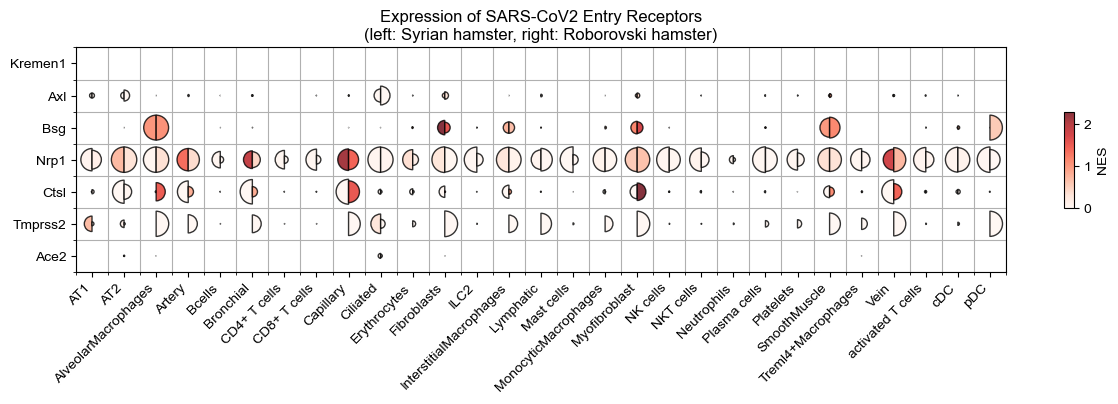

In [258]:
split_dotplot(mean_expressions['Syrian hamster'], percent_expressings['Syrian hamster'], 
              mean_expressions['Roborovski hamster'], percent_expressings['Roborovski hamster'], 
              figsize=(15,5), ax=None, dpi=None, title="Expression of SARS-CoV2 Entry Receptors\n(left: Syrian hamster, right: Roborovski hamster)", 
              show=False)
pl.savefig("../results/figures/Revision/Rev1_Major3b_Entry_receptor_expression_splitdots.pdf", bbox_inches='tight', dpi=300)
pl.show()

# Sex

ValueError: color key is invalid! pass valid observation annotation or a gene name

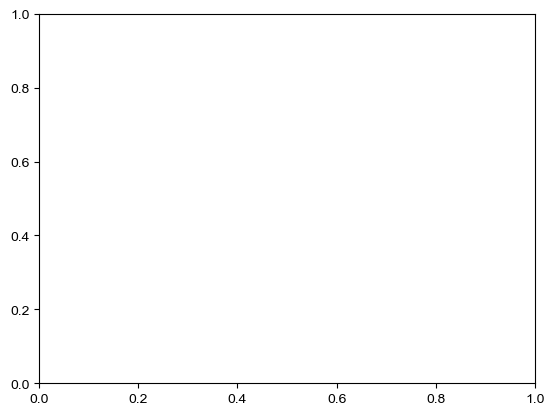

In [142]:
scv.pl.scatter(superdata, basis='umap_scVI', color='Hprt', legend_loc='on data', frameon=False, title='Cell type annotation', color_map=celltype_rough_colors)

In [130]:
sex_marker = ['']

40

In [131]:
superdata.var_names[superdata.var_names.str.startswith('X')]

Index(['Xab2', 'Xaf1', 'Xbp1', 'Xcl1', 'Xcr1', 'Xdh', 'Xg', 'Xk', 'Xkr6',
       'Xkr7', 'Xkr8', 'Xkr9', 'Xkrx', 'Xlr4a', 'Xntrpc', 'Xpa', 'Xpc',
       'Xpnpep1', 'Xpnpep2', 'Xpnpep3', 'Xpo1', 'Xpo4', 'Xpo5', 'Xpo6', 'Xpo7',
       'Xpot', 'Xpr1', 'Xrcc1', 'Xrcc2', 'Xrcc3', 'Xrcc4', 'Xrcc5', 'Xrcc6',
       'Xrn1', 'Xrn2', 'Xrra1', 'Xxylt1', 'Xylb', 'Xylt1', 'Xylt2'],
      dtype='object')

In [144]:
sdata = sc.read_10x_h5("/Users/peidli/work/data/COVID/GEO_submission_PhoRob_timecourse/processed_files/raw_count_data/cellranger_pr-D0-Z2_filtered_feature_bc_matrix.h5")

In [146]:
'Xist' in sdata.var_names

False

In [147]:
'Uty' in sdata.var_names

True

In [149]:
sdata[:, 'Rbmy']

KeyError: 'Rbmy'

In [148]:
sdata.var

,gene_ids,feature_types,genome
Rmi2,gene_5099,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
Tnp2,gene_5037,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
Socs1,gene_5038,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
Snn,gene_5202,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
Olfr59,gene_4821,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
...,...,...,...
SCoV2_ORF6,SCoV2_ORF6,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
SCoV2_ORF7a,SCoV2_ORF7a,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
SCoV2_ORF8,SCoV2_ORF8,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
SCoV2_N,SCoV2_N,Gene Expression,refdata-cellranger-pr1_fixed_names_filtered_co...
